In [1]:

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#from statistics import mean
#from scipy import integrate
#from scipy.signal import lfilter
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
#import statistics
#import copy
from pandas import *

In [ ]:
# this file makes 6 figures in current paper:
#   upeak.png apeak.png:
#       showing peak velocities as a function of impact angle and at 4 different positions
#       uprange and downrange and ratio
#   Rpulse_downrange.png, Rpulse_uprange.png and
#   Rpulse_downrange2.png, Rpulse_uprange2.png:
#       These show pulse velocity amplitude as a function of time and velocity angle as a function of time


# required datasets: t36c.csv -- t86c.csv and t36f.csv -- t86f.csv taken June/July 2023

In [2]:
## acc voltage to real units m/s^2 conversion factors (calibration factors for accelerometers)
## [y1,x1,z1, y2,x2,z2] acc channels
cal_F2F3 = [0.00601427, 0.0059633, 0.0059633, 0.00606523, 0.00606523, 0.0059633] # +-16g
cal_F5F7  = [0.0328, 0.0325, 0.0322, 0.0324, 0.0328, 0.0327]  # +-3g
colorlist = ['red','orange','gold','green','cyan','blue','violet','grey','brown']
cal_F1F2 = [0.006473,0.006116,0.0062181,0.00601427,0.006014271,0.006014271]  # +-16g

In [137]:
# properties of experiments
dt = 1/2e5 # in seconds  -- from 200 kHz sampling rate
dt_ms = dt*1e3
datadir = './acc_data/junejuly_23/'
v_imp = 104.0  # impact velocity  m/s
rho_s = 1500.  # sand density kg/m^3
M_p = 0.20*1e-3 # g to kg projectile mass
K_imp = 0.5*M_p*v_imp**2  #kinetic energy of projectile
R_cr = 3.5*1e-2 # cm to m
k_seis = 1e-3
B_eff = 1.0
v_pk_Cr_E = np.sqrt(k_seis*K_imp/(2*np.pi*R_cr**3*rho_s))  #eqn 49 by Q+22
v_pk_Cr_P = B_eff*M_p*v_imp/(rho_s*2*np.pi*R_cr**3)  #Eqn 50 by Q+22
print('v_pk= {:.3f} vp_k = {:.3f} m/s'.format(v_pk_Cr_E,v_pk_Cr_P ))

v_pk= 0.052 vp_k = 0.051 m/s


In [4]:
# read in csv file output by oscilloscope
# cal is a calibration file for 6 accelerometer channels
# t_impact is estimate for time of impact in ms
# first_second is 0 or 1 depending upon whether you want the first accelerometer or the second
# the resulting data arrays only contain 3 axes of a single accelerometer

ilen = 3000  # how many data samples I am going to store!
def read_data(file_name,cal,t_impact,first_second):
    data_array = np.zeros([4,ilen])
    col = ['Time', 'Channel A', 'Channel B', 'Channel C','Channel E','Channel F','Channel G'] # defined columns
    col_list = [0,1,2,3,4,5,6]
    data_pd = pd.read_csv(file_name, usecols = col_list,dtype=float,skiprows=[1])   # array in pandas
    # time array is supposed to be in seconds
    data_pd['Time']*= 1000.0  # time now in ms
    data_pd['Time'] -= t_impact
    i0 = np.argmin(np.abs(data_pd['Time']+3))  # 3 ms prior to impact 
    mmarr = np.zeros(6)
    for i in range(1,7):
        data_pd[col[i]]/= cal[i-1]  # calibrate to m/s^2
        mm = np.median(data_pd[col[i]])
        #data_pd[col[i]]-= mm  #median not subtracted here!!!! 
        mmarr[i-1] = mm
    #print(mmarr)
    data_array[0,:] = np.array(data_pd['Time'][i0:i0+ilen])
    if (first_second==0):
        for i in range(1,4):
            data_array[i,:] = data_pd[col[i]][i0:i0+ilen]  #limit size of arrays in time 
    else: 
        for i in range(1,4):
            data_array[i,:] = data_pd[col[i+3]][i0:i0+ilen]  #limit size of arrays
    return data_pd, data_array

In [ ]:
#List of data that I want for this 
#order for channels 
#theta_i  file     columns 
#date: 
#10       t45c     t a_z a_R a_y a_z a_R a_y  accelerometer channels: are y,x,z, y,x,z
#                     F2          F3   acclerometer
#         t45f     t a_z a_R a_y a_z a_R a_y 
#                     F5          F7
#F2,F5 are uprange? and F3,F7 are downrange?
#c = close,  f = far 

#t45c has z=5, R=6 
#t45f has z=5, R=10  
#sampling rate is 200kHz

In [5]:
# read in all data into cubes, all at one radius/depth,  including uprange downrange
def read_data_set(datadir,cal,dfilelist,t_impact_list):
    n_theta_I = len(t_impact_list)
    data_cube_uprange   = np.zeros([n_theta_I,4,ilen])
    data_cube_downrange = np.zeros([n_theta_I,4,ilen])
    for i in range(n_theta_I):
        filename = datadir + dfilelist[i]
        t_impact=t_impact_list[i]
        data_pd0,data_array0 = read_data(filename,cal,t_impact,0)  # downrange
        data_pd1,data_array1 = read_data(filename,cal,t_impact,1)  # uprange
        #print(data_array.shape)
        for j in range(4):
            data_cube_uprange[i,j,:]  = np.squeeze(data_array1[j,:])
            data_cube_downrange[i,j,:]  = np.squeeze(data_array0[j,:])
    return data_cube_uprange,data_cube_downrange
# put data in cubes!

def rot_xy(x,y,phi):
    xp = np.cos(phi)*x + np.sin(phi)*y
    yp = np.sin(phi)*x - np.cos(phi)*y
    return xp,yp

# trying to correct rotation in R vs t (xy axes of accelerometer)
def corr_rot(data_cube):
    new_data_cube = np.copy(data_cube)
    nt = data_cube.shape[0]
    alin = np.linspace(-0.3,0.3,30)
    dist = alin*0
    tarr = np.squeeze(data_cube[0,0,:])
    for i in range(nt):
        a_R = np.squeeze(data_cube[i,2,:])
        a_z = np.squeeze(data_cube[i,1,:])
        a_t = np.squeeze(data_cube[i,3,:])
        for j in range(len(alin)):
            a_R_new,a_t_new = rot_xy(a_R,a_t,alin[j])
            dist[j] = np.sum(a_t_new**2) 
        jj = np.argmin(dist)
        a_R_new,a_t_new = rot_xy(a_R,a_t,alin[jj])
        new_data_cube[i,2,:]= a_R_new
        new_data_cube[i,3,:]= a_t_new
        print(alin[jj])
        #plt.plot(tarr,a_R_new)
        #plt.plot(tarr,a_t_new)
    return new_data_cube
            
        

In [6]:
# do integration to create velocity signals from acceleration signals
# here dt is sampling spacing in time
def mkvels(data_cube,dt):
    adata = np.copy(data_cube)  # medianed accel data cube
    vdata = adata*0  # velocity cube
    nt = data_cube.shape[0]
    new_adata = np.copy(adata)
    for i in range(nt):   # loop over impact angles 
        tarr = np.squeeze(data_cube[i,0,:])
        i0 = np.argmin(np.abs(tarr))
        vdata[i,0,:] = tarr # copy time arrays over to velocity cube
        # subtract off median prior to impact
        for j in range(1,4):  # loop over three axes
            mm = np.mean(data_cube[i,j,0:i0])
            adata[i,j,:] = data_cube[i,j,:] - mm
    new_adata = corr_rot(adata)  # correct via rotation?
    
    # integrate velocity
    for i in range(nt):
        for j in range(1,4):
            data = np.squeeze(new_adata[i,j,:])
            vdata[i,j,:] = np.cumsum(data)*dt
    return new_adata,vdata 
    # returns both accelerations and velocities 



In [7]:
# compute the velocity magnitude given index of impact angle
# also compute the angle of the velocity vector as a function of time
# this routine could be run on acceleration cube instead of velocity cube
def umag(cube,theta_i):
    uz = np.squeeze(cube[theta_i,1,:])
    uR = np.squeeze(cube[theta_i,2,:])
    ut = np.squeeze(cube[theta_i,3,:])
    theta = np.arctan2(uz,uR)  # computes spherical coordinate angle?
    um = np.sqrt(uR**2 + uz**2 + ut**2)  # magnitude of velocity 
    return um,theta
# returns magnitude of velocity or acceleration (depending upon cube) for a particular impact angle

# to find velocity component we need to know positions of accelerometers R,z
def ur_cube(cube,theta_i,R,z):
    uz = np.squeeze(cube[theta_i,1,:])
    uR = np.squeeze(cube[theta_i,2,:])
    ut = np.squeeze(cube[theta_i,3,:])
    r = np.sqrt(R**2 + z**2)
    rhat_x = R/r; rhat_z = z/r
    u_r = uR*rhat_x + uz*rhat_z  # spherical coordinates radial component 
    return u_r

def find_peaks_angles(upcube,downcube,R,z):
    nt = upcube.shape[0]
    u_up   = np.zeros(nt)
    u_down = np.zeros(nt)
    theta_up   = np.zeros(nt)
    theta_down = np.zeros(nt)
    ur_up = np.zeros(nt)
    ur_down = np.zeros(nt)
    for i in range(nt):
        u, theta = umag(upcube,i)
        imax = np.argmax(u)
        u_up[i] = u[imax]
        theta_up[i] = theta[imax]
        u, theta = umag(downcube,i)
        imax = np.argmax(u)
        u_down[i] = u[imax]
        theta_down[i] = theta[imax]
    for i in range(nt):
        u_r = ur_cube(upcube,i,R,z)
        imax = np.argmax(u_r)
        ur_up[i] = u_r[imax]
        u_r = ur_cube(downcube,i,R,z)
        imax = np.argmax(u_r)
        ur_down[i] = u_r[imax]
        
    return u_up,u_down,theta_up,theta_down,ur_up,ur_down


def display4(data_cube_uprange,data_cube_downrange):
    fig,axarr = plt.subplots(2,2,sharex=True,figsize=(7,3))
    plt.subplots_adjust(hspace=0,wspace=0.2)
    axarr[0,0].set_xlim([-1,6])
    nt = data_cube_uprange.shape[0]
    for i in range(nt):
        axarr[0,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,2,:],color=colorlist[i]) # a_R if adata given
        axarr[1,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,1,:],color=colorlist[i]) # a_Z
        axarr[0,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,2,:],color=colorlist[i]) # a_R
        axarr[1,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,1,:],color=colorlist[i]) # a_Z
        
        
def display6(data_cube_uprange,data_cube_downrange):
    fig,axarr = plt.subplots(3,2,sharex=True,figsize=(7,3))
    plt.subplots_adjust(hspace=0,wspace=0.2)
    axarr[0,0].set_xlim([-1,6])
    nt = data_cube_uprange.shape[0]
    for i in range(nt):
        axarr[0,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,2,:],color=colorlist[i]) # a_R if adata given
        axarr[1,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,1,:],color=colorlist[i]) # a_Z
        axarr[2,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,3,:],color=colorlist[i]) # a_t
        axarr[0,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,2,:],color=colorlist[i]) # a_R
        axarr[1,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,1,:],color=colorlist[i]) # a_Z
        axarr[2,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,3,:],color=colorlist[i]) # a_t
    axarr[0,0].set_ylabel('R') 
    axarr[1,0].set_ylabel('z')
    axarr[2,0].set_ylabel('perp') 
    axarr[2,1].set_xlabel('downrange')
    axarr[2,0].set_xlabel('uprange')
        

# not finished editing this routine
def display4_angs(data_cube_uprange,data_cube_downrange):
    fig,axarr = plt.subplots(2,2,sharex=True,figsize=(7,3))
    plt.subplots_adjust(hspace=0,wspace=0.2)
    axarr[0,0].set_xlim([-1,6])
    nt = data_cube_uprange.shape[0]
    for i in range(nt):
        axarr[0,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,2,:],color=colorlist[i]) # a_R if adata given
        axarr[1,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,1,:],color=colorlist[i]) # a_z
        axarr[0,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,2,:],color=colorlist[i]) # a_R
        axarr[1,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,1,:],color=colorlist[i]) # a_z

In [128]:
# I am going to store a particular radius and depth at different impact angles
# R=6, z=5

dfilelist  = ['t45c.csv','t36c.csv','t47c.csv','t38c.csv','t49c.csv','t40c.csv','t51c.csv','t42c.csv','t53c.csv']
thetalist_R6z5 = np.array([10., 20,         30,        40,          50,      60,        70,         80,     90 ])
t_impact_list = np.array([796.5, 567.6, 770.9,   577.3,       790.1,     582.7,     781.5+0.1, 579.2-0.2, 774.])
# these should all have radius of R=6 , z =5
#n_theta_I = len(t_impact_list)
R= 6.0; z=5.0
r_R6z5 = np.sqrt(R**2 + z**2)

data_cube_uprange_R6z5,data_cube_downrange_R6z5 = read_data_set(datadir,cal_F2F3,dfilelist,t_impact_list)
adata_cube_uprange_R6z5,   vdata_cube_uprange_R6z5   = mkvels(data_cube_uprange_R6z5,dt)
adata_cube_downrange_R6z5, vdata_cube_downrange_R6z5 = mkvels(data_cube_downrange_R6z5,dt)
u_up_R6z5,u_down_R6z5,theta_up_R6z5,theta_down_R6z5,ur_up_R6z5,ur_down_R6z5 = \
    find_peaks_angles(vdata_cube_uprange_R6z5,vdata_cube_downrange_R6z5,R,z)
a_up_R6z5,a_down_R6z5,atheta_up_R6z5,atheta_down_R6z5,ar_up_R6z5,ar_down_R6z5 = \
    find_peaks_angles(adata_cube_uprange_R6z5,adata_cube_downrange_R6z5,R,z)

-0.11379310344827587
-0.19655172413793104
-0.13448275862068965
-0.11379310344827587
-0.010344827586206862
0.010344827586206917
-0.010344827586206862
-0.09310344827586206
-0.010344827586206862
0.19655172413793104
0.25862068965517243
0.11379310344827587
0.051724137931034475
0.21724137931034487
0.11379310344827587
0.031034482758620696
0.13448275862068965
-0.051724137931034475


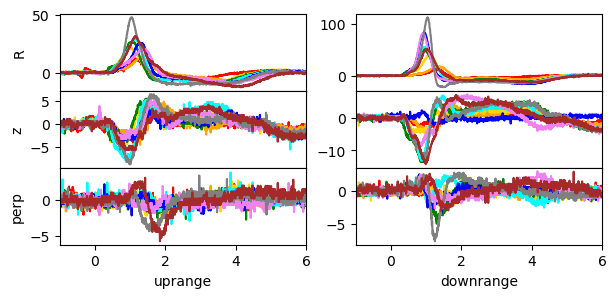

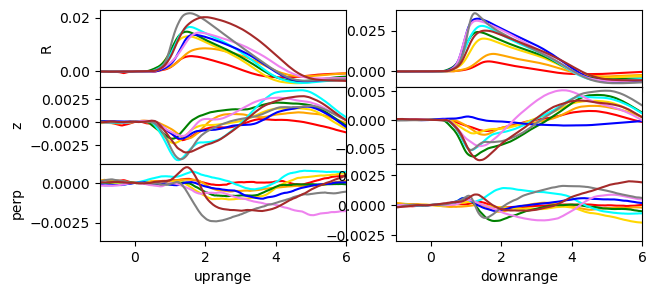

In [9]:
display6(adata_cube_uprange_R6z5,adata_cube_downrange_R6z5) # a_R, a_Z up/down range
display6(vdata_cube_uprange_R6z5,vdata_cube_downrange_R6z5) # v_R, v_Z up/down range

Text(0.5, 0, 'time (ms)')

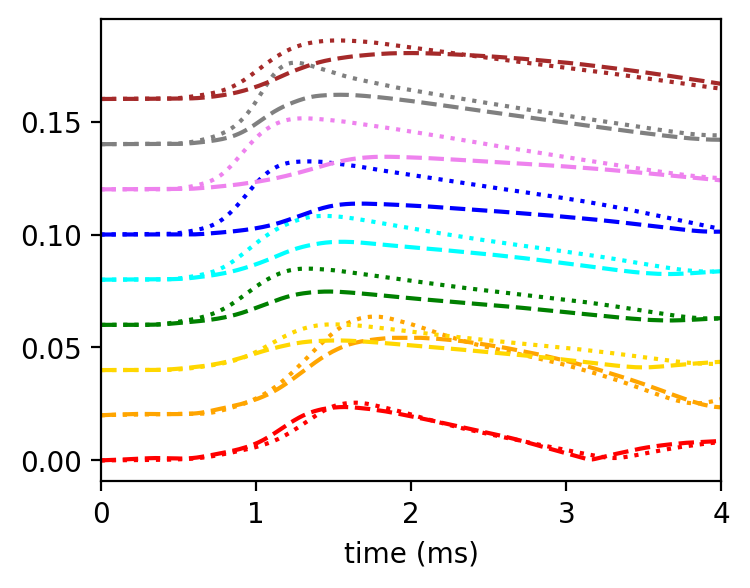

In [10]:
fig,ax = plt.subplots(1,1,facecolor='white',figsize=(4,3),dpi=200)
ax.set_xlim([-0.0,4])
for i in range(len(thetalist_R6z5)):
    u_up, theta_up = umag(vdata_cube_uprange_R6z5,i)
    u_dn, theta_dn = umag(vdata_cube_downrange_R6z5,i)
    if (i<2):
        u_up*=4 
        u_dn*=4 
    #u_ratio = (u_dn_R6z5 - u_up_R6z5)/(u_up_R6z5 + u_dn_R6z5)
    #ax.plot(vdata_cube_uprange[i,0,:],20*u_ratio+20*i,color=colorlist[i])
    ax.plot(vdata_cube_uprange_R6z5[i,0,:],u_dn+i*20e-3,':',color=colorlist[i])
    ax.plot(vdata_cube_uprange_R6z5[i,0,:],u_up+i*20e-3,'--',color=colorlist[i])
ax.set_xlabel(r'time (ms)')
#ax.plot(thetalist,u_up,'ro',label='uprange')   #  velocity peaks as a function of  impact angle
#ax.plot(thetalist,u_down,'bs',label='downrange')
#ax.set_xlabel(r'Impact angle $\theta_I$ (deg)')
#ax.set_ylabel(r'$|u|_{peak}$ (m/s)')
#ax.legend()

-0.09310344827586206
-0.010344827586206862
-0.010344827586206862
-0.09310344827586206
-0.010344827586206862
0.07241379310344825
0.07241379310344825
0.031034482758620696
0.21724137931034487
0.3
0.010344827586206917
0.15517241379310348
0.010344827586206917
0.15517241379310348
-0.010344827586206862
0.051724137931034475
0.051724137931034475
-0.031034482758620696


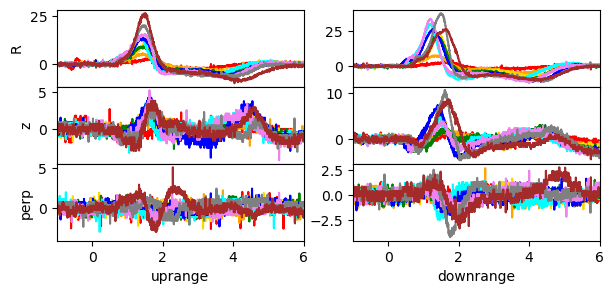

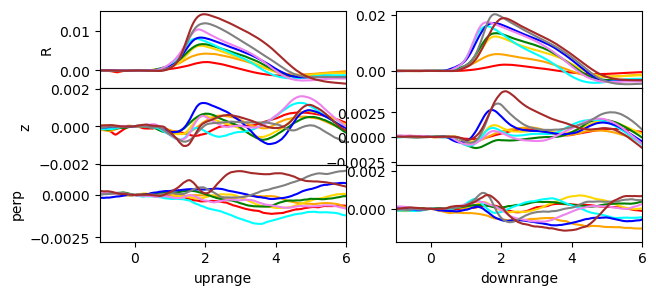

In [129]:
############## lets look at R=8,z=5
dfilelist  = ['t46c.csv','t37c.csv','t48c.csv','t39c.csv','t50c.csv','t41c.csv','t52c.csv','t43c.csv','t54c.csv']
thetalist_R8z5 = np.array([10., 20,         30,        40,          50,      60,        70,         80,     90 ])
t_impact_list = np.array([805.4, 572.5, 779.5,   563.7,       791.5,  585.6+0.15,   764.9,     570.4-0.25, 764.2])
# these should all have radius of R=8 , z =5
R= 8.0; z=5.0
#n_theta_I = len(t_impact_list)
r_R8z5 = np.sqrt(R**2 + z**2)

data_cube_uprange_R8z5,data_cube_downrange_R8z5 = read_data_set(datadir,cal_F2F3,dfilelist,t_impact_list)
adata_cube_uprange_R8z5,   vdata_cube_uprange_R8z5   = mkvels(data_cube_uprange_R8z5,dt)
adata_cube_downrange_R8z5, vdata_cube_downrange_R8z5 = mkvels(data_cube_downrange_R8z5,dt)
u_up_R8z5,u_down_R8z5,theta_up_R8z5,theta_down_R8z5,ur_up_R8z5,ur_down_R8z5  = \
    find_peaks_angles(vdata_cube_uprange_R8z5,vdata_cube_downrange_R8z5,R,z)
a_up_R8z5,a_down_R8z5,atheta_up_R8z5,atheta_down_R8z5,ar_up_R8z5,ar_down_R8z5  = \
    find_peaks_angles(adata_cube_uprange_R8z5,adata_cube_downrange_R8z5,R,z)

display6(adata_cube_uprange_R8z5,adata_cube_downrange_R8z5) # a_R, a_Z up/down range
display6(vdata_cube_uprange_R8z5,vdata_cube_downrange_R8z5) # v_R, v_Z up/down range

Text(0.5, 0, 'time (ms)')

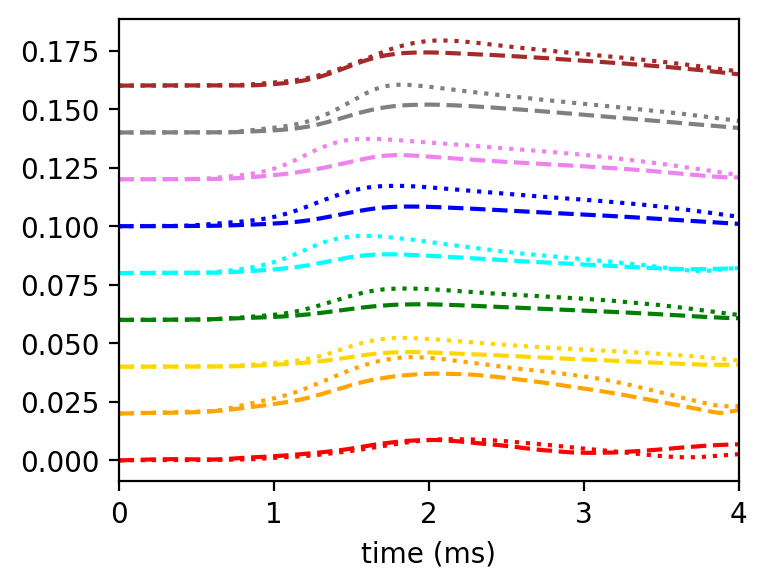

In [14]:
fig,ax = plt.subplots(1,1,facecolor='white',figsize=(4,3),dpi=200)
ax.set_xlim([-0.0,4])
for i in range(len(thetalist_R8z5)):
    u_up, theta_up = umag(vdata_cube_uprange_R8z5,i)
    u_dn, theta_dn = umag(vdata_cube_downrange_R8z5,i)
    if (i<2):
        u_up*=4 
        u_dn*=4 
    u_ratio = (u_dn - u_up)/(u_up + u_dn)
    #ax.plot(vdata_cube_uprange[i,0,:],20*u_ratio+20*i,color=colorlist[i])
    ax.plot(vdata_cube_uprange_R8z5[i,0,:],u_dn+i*20e-3,':',color=colorlist[i])
    ax.plot(vdata_cube_uprange_R8z5[i,0,:],u_up+i*20e-3,'--',color=colorlist[i])
ax.set_xlabel(r'time (ms)')

0.13448275862068965
-0.13448275862068965
-0.051724137931034475
-0.010344827586206862
-0.09310344827586206
-0.11379310344827587
0.07241379310344825
-0.010344827586206862
0.07241379310344825
0.17586206896551726
0.13448275862068965
-0.010344827586206862
0.031034482758620696
0.010344827586206917
0.07241379310344825
0.010344827586206917


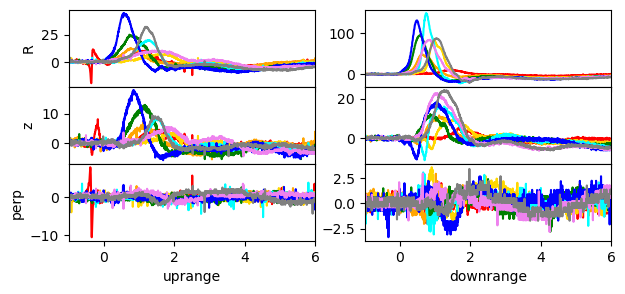

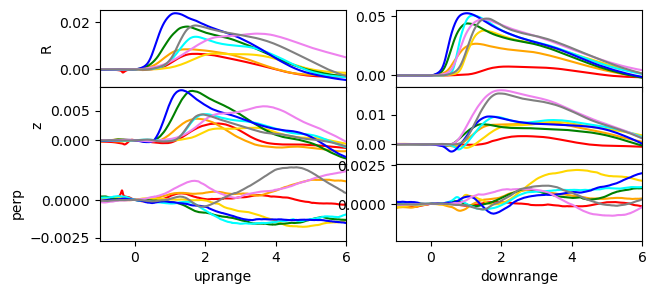

In [130]:
############## lets look at R=6, z=3

dfilelist  = ['t86c.csv','t79c.csv','t82c.csv','t70c.csv','t83c.csv','t61c.csv','t84c.csv','t85c.csv']
thetalist_R6z3 = np.array([10.,   20., 30, 40,    50,     60,70,80])
t_impact_list = np.array([854.4,   582.4, 914.4, 575.2, 932.6, 592.9,882.2,946.7])
# these should all have radius of R=6 , z =3
R=6.0;z=3.0
#n_theta_I = len(t_impact_list)
r_R6z3 = np.sqrt(R**2 + z**2)

data_cube_uprange_R6z3,data_cube_downrange_R6z3 = read_data_set(datadir,cal_F1F2,dfilelist,t_impact_list)
adata_cube_uprange_R6z3,   vdata_cube_uprange_R6z3   = mkvels(data_cube_uprange_R6z3,dt)
adata_cube_downrange_R6z3, vdata_cube_downrange_R6z3 = mkvels(data_cube_downrange_R6z3,dt)
u_up_R6z3,u_down_R6z3,theta_up_R6z3,theta_down_R6z3,ur_up_R6z3,ur_down_R6z3  = \
    find_peaks_angles(vdata_cube_uprange_R6z3,vdata_cube_downrange_R6z3,R,z)
a_up_R6z3,a_down_R6z3,atheta_up_R6z3,atheta_down_R6z3,ar_up_R6z3,ar_down_R6z3  = \
    find_peaks_angles(adata_cube_uprange_R6z3,adata_cube_downrange_R6z3,R,z)

display6(adata_cube_uprange_R6z3,adata_cube_downrange_R6z3) # a_R, a_Z up/down range
display6(vdata_cube_uprange_R6z3,vdata_cube_downrange_R6z3) # v_R, v_Z up/down range

Text(0.5, 0, 'time (ms)')

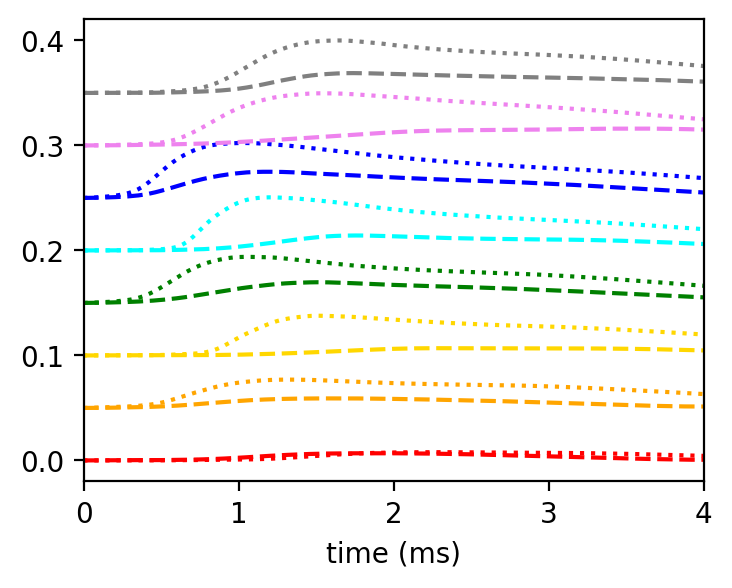

In [16]:
fig,ax = plt.subplots(1,1,facecolor='white',figsize=(4,3),dpi=200)
ax.set_xlim([-0.0,4])
for i in range(len(thetalist_R6z3)):
    u_up, theta_up = umag(vdata_cube_uprange_R6z3,i)
    u_dn, theta_dn = umag(vdata_cube_downrange_R6z3,i)
    #if (i<2):
    #    u_up*=2 
     #   u_dn*=2 
    #u_ratio = (u_dn - u_up)/(u_up + u_dn)
    #ax.plot(vdata_cube_uprange[i,0,:],20*u_ratio+50*i,color=colorlist[i])
    ax.plot(vdata_cube_uprange_R6z3[i,0,:],u_dn+i*50e-3,':',color=colorlist[i])
    ax.plot(vdata_cube_uprange_R6z3[i,0,:],u_up+i*50e-3,'--',color=colorlist[i])
ax.set_xlabel(r'time (ms)')

0.15517241379310348
0.051724137931034475
-0.010344827586206862
0.15517241379310348
0.09310344827586209
0.09310344827586209


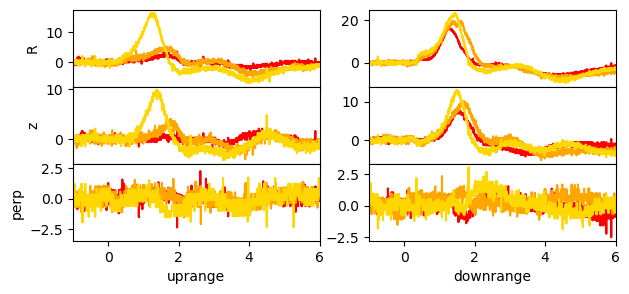

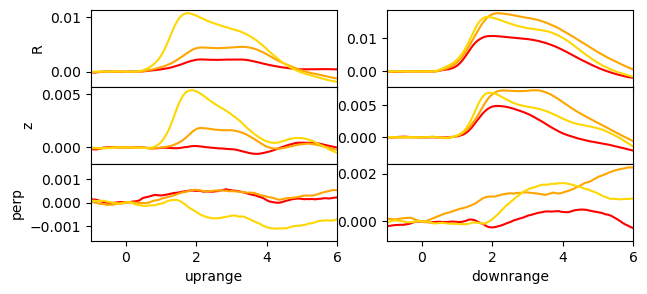

In [131]:
############## lets look at R=8, z=3
dfilelist  = ['t80c.csv','t71c.csv','t62c.csv']
thetalist_R8z3 = np.array([20., 40,  60])
t_impact_list = np.array([594.7, 577.3, 592.2])
R=8.0; z=3.0;
#n_theta_I = len(t_impact_list)
r_R8z3 = np.sqrt(R**2 + z**2)

data_cube_uprange_R8z3,data_cube_downrange_R8z3 = read_data_set(datadir,cal_F1F2,dfilelist,t_impact_list)
adata_cube_uprange_R8z3,   vdata_cube_uprange_R8z3   = mkvels(data_cube_uprange_R8z3,dt)
adata_cube_downrange_R8z3, vdata_cube_downrange_R8z3 = mkvels(data_cube_downrange_R8z3,dt)
u_up_R8z3,u_down_R8z3,theta_up_R8z3,theta_down_R8z3,ur_up_R8z3,ur_down_R8z3  = \
    find_peaks_angles(vdata_cube_uprange_R8z3,vdata_cube_downrange_R8z3,R,z)
a_up_R8z3,a_down_R8z3,atheta_up_R8z3,atheta_down_R8z3,ar_up_R8z3,ar_down_R8z3  = \
    find_peaks_angles(adata_cube_uprange_R8z3,adata_cube_downrange_R8z3,R,z)

display6(adata_cube_uprange_R8z3,adata_cube_downrange_R8z3) # a_R, a_Z up/down range
display6(vdata_cube_uprange_R8z3,vdata_cube_downrange_R8z3) # v_R, v_Z up/down range

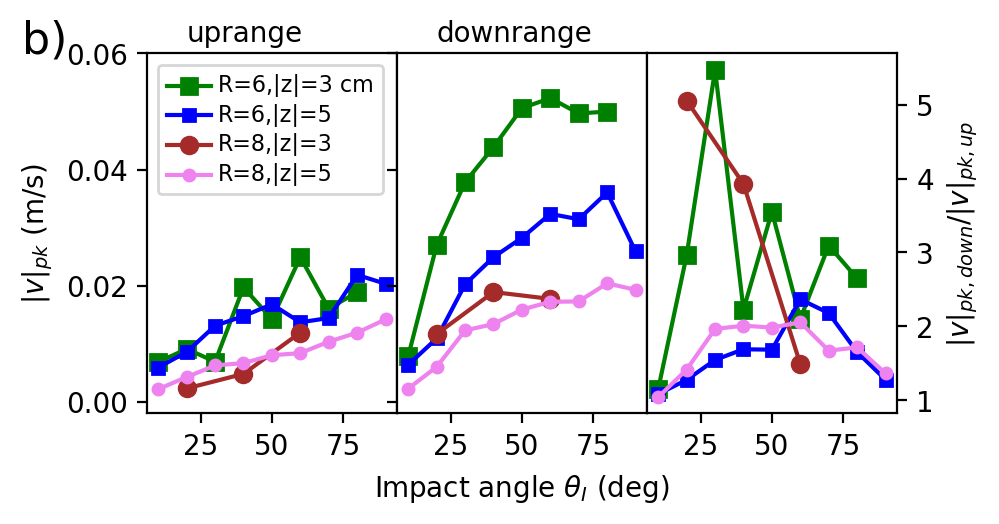

In [18]:
fig,axarr = plt.subplots(1,3,facecolor='white',figsize=(5,2.5),dpi=200,sharex=True,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0,bottom=0.18,top=0.90,right=0.90,left=0.15)
axarr[1].set_xlabel(r'Impact angle $\theta_I$ (deg)')
#axarr[0].set_xlabel(r'Impact angle $\theta_I$ (deg)')


#  velocity peaks as a function of  impact angle
axarr[0].plot(thetalist_R6z3,u_up_R6z3,'gs-',label='R=6,|z|=3 cm',ms=6) 
axarr[0].plot(thetalist_R6z5,u_up_R6z5,'bs-',label='R=6,|z|=5',ms=4) 
axarr[0].plot(thetalist_R8z3,u_up_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown') 
axarr[0].plot(thetalist_R8z5,u_up_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet') 
axarr[0].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
               loc='upper left') # title='uprange',
#axarr[0].text(30,0.056,'uprange')
axarr[0].set_ylabel(r'$|v|_{pk}$ (m/s)')
axarr[0].set_ylim(bottom=-0.002,top=0.06)
axarr[0].text(20,0.062,'uprange')
axarr[1].text(20,0.062,'downrange')
#axarr[2].text(20,5.8,'ratio')

axarr[1].plot(thetalist_R6z3,u_down_R6z3,'gs-',label='R=6,|z|=3',ms=6)
axarr[1].plot(thetalist_R6z5,u_down_R6z5,'bs-',label='R=6,|z|=5',ms=4)
axarr[1].plot(thetalist_R8z3,u_down_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown')
axarr[1].plot(thetalist_R8z5,u_down_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet')
#axarr[1].text(30,0.056,'downrange')

#axarr[1].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
#               title='downrange',bbox_to_anchor=[-0.3,0.5,0.5,0.5])
axarr[1].set_ylim(bottom=-0.002,top=0.06)
axarr[1].set_yticklabels([])
#ax.set_xticks([])


axarr[2].plot(thetalist_R6z3,u_down_R6z3/u_up_R6z3,'gs-',label='R=6,|z|=3',ms=6)
axarr[2].plot(thetalist_R6z5,u_down_R6z5/u_up_R6z5,'bs-',label='R=6,|z|=5',ms=4)
axarr[2].plot(thetalist_R8z3,u_down_R8z3/u_up_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown')
axarr[2].plot(thetalist_R8z5,u_down_R8z5/u_up_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet')
#axarr[2].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
#               title='ratio',bbox_to_anchor=[-0.3,0.5,0.5,0.5])
axarr[2].yaxis.set_label_position("right")
axarr[2].yaxis.tick_right()
axarr[2].set_ylabel(r'$|v|_{pk,down}/|v|_{pk,up}$')

axarr[0].text(-38,0.06,'b)',fontsize=16)
plt.savefig('upeak.png',dpi=200)
#ax.legend()
#ax.text(25,2.5,'R=8 cm,|z|=5 cm')

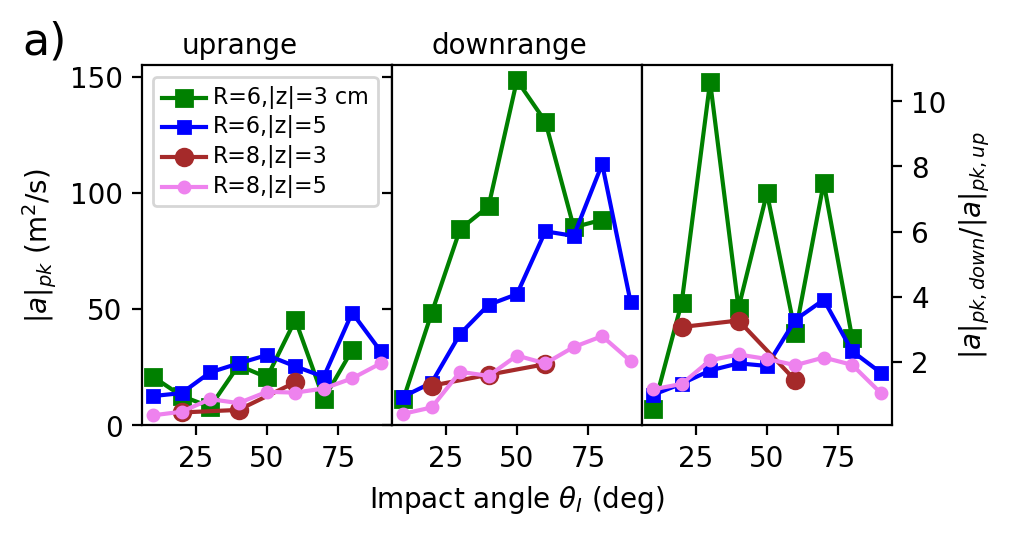

In [19]:
fig,axarr = plt.subplots(1,3,facecolor='white',figsize=(5,2.5),dpi=200,sharex=True,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0,bottom=0.18,top=0.90,right=0.90,left=0.15)
axarr[1].set_xlabel(r'Impact angle $\theta_I$ (deg)')
#axarr[0].set_xlabel(r'Impact angle $\theta_I$ (deg)')

#  velocity peaks as a function of  impact angle
axarr[0].plot(thetalist_R6z3,a_up_R6z3,'gs-',label='R=6,|z|=3 cm',ms=6) 
axarr[0].plot(thetalist_R6z5,a_up_R6z5,'bs-',label='R=6,|z|=5',ms=4) 
axarr[0].plot(thetalist_R8z3,a_up_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown') 
axarr[0].plot(thetalist_R8z5,a_up_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet') 
axarr[0].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
               loc='upper left')
#axarr[0].text(30,0.056,'uprange')
axarr[0].set_ylim(bottom=-0.002,top=155)
axarr[1].set_ylim(bottom=-0.002,top=155)
axarr[0].text(20,160,'uprange')
axarr[1].text(20,160,'downrange')

axarr[1].plot(thetalist_R6z3,a_down_R6z3,'gs-',label='R=6,|z|=3',ms=6)
axarr[1].plot(thetalist_R6z5,a_down_R6z5,'bs-',label='R=6,|z|=5',ms=4)
axarr[1].plot(thetalist_R8z3,a_down_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown')
axarr[1].plot(thetalist_R8z5,a_down_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet')
#axarr[1].text(30,0.056,'downrange')
axarr[1].set_yticklabels([])

axarr[2].plot(thetalist_R6z3,a_down_R6z3/a_up_R6z3,'gs-',label='R=6,|z|=3',ms=6)
axarr[2].plot(thetalist_R6z5,a_down_R6z5/a_up_R6z5,'bs-',label='R=6,|z|=5',ms=4)
axarr[2].plot(thetalist_R8z3,a_down_R8z3/a_up_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown')
axarr[2].plot(thetalist_R8z5,a_down_R8z5/a_up_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet')
axarr[2].yaxis.set_label_position("right")
axarr[2].yaxis.tick_right()
axarr[2].set_ylabel(r'$|a|_{pk,down}/|a|_{pk,up}$')

#axarr[1].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
#               title='downrange',bbox_to_anchor=[-0.1,0.5,0.5,0.5])
axarr[0].set_ylabel(r'$|a|_{pk}$ (m$^2$/s)')
axarr[0].set_ylim(bottom=-0.002)
axarr[0].text(-36,160,'a)',fontsize=16)
plt.savefig('apeak.png',dpi=200)
#ax.legend()
#ax.text(25,2.5,'R=8 cm,|z|=5 cm')

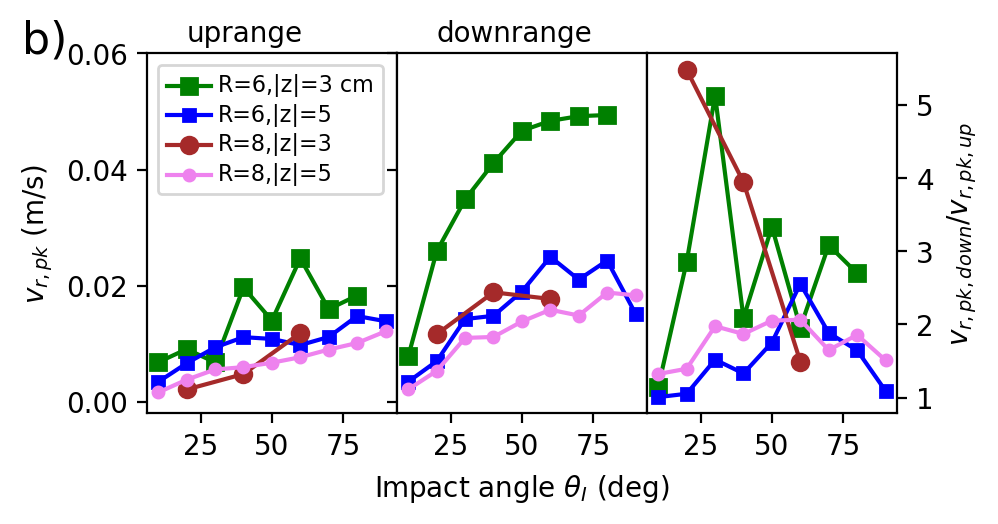

In [20]:
fig,axarr = plt.subplots(1,3,facecolor='white',figsize=(5,2.5),dpi=200,sharex=True,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0,bottom=0.18,top=0.90,right=0.90,left=0.15)
axarr[1].set_xlabel(r'Impact angle $\theta_I$ (deg)')
#axarr[0].set_xlabel(r'Impact angle $\theta_I$ (deg)')


#  velocity peaks as a function of  impact angle
axarr[0].plot(thetalist_R6z3,ur_up_R6z3,'gs-',label='R=6,|z|=3 cm',ms=6) 
axarr[0].plot(thetalist_R6z5,ur_up_R6z5,'bs-',label='R=6,|z|=5',ms=4) 
axarr[0].plot(thetalist_R8z3,ur_up_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown') 
axarr[0].plot(thetalist_R8z5,ur_up_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet') 
axarr[0].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
               loc='upper left') # title='uprange',
#axarr[0].text(30,0.056,'uprange')
axarr[0].set_ylabel(r'$v_{r,pk}$ (m/s)')
axarr[0].set_ylim(bottom=-0.002,top=0.06)
axarr[0].text(20,0.062,'uprange')
axarr[1].text(20,0.062,'downrange')
#axarr[2].text(20,5.8,'ratio')

axarr[1].plot(thetalist_R6z3,ur_down_R6z3,'gs-',label='R=6,|z|=3',ms=6)
axarr[1].plot(thetalist_R6z5,ur_down_R6z5,'bs-',label='R=6,|z|=5',ms=4)
axarr[1].plot(thetalist_R8z3,ur_down_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown')
axarr[1].plot(thetalist_R8z5,ur_down_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet')
#axarr[1].text(30,0.056,'downrange')

#axarr[1].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
#               title='downrange',bbox_to_anchor=[-0.3,0.5,0.5,0.5])
axarr[1].set_ylim(bottom=-0.002,top=0.06)
axarr[1].set_yticklabels([])
#ax.set_xticks([])


axarr[2].plot(thetalist_R6z3,ur_down_R6z3/ur_up_R6z3,'gs-',label='R=6,|z|=3',ms=6)
axarr[2].plot(thetalist_R6z5,ur_down_R6z5/ur_up_R6z5,'bs-',label='R=6,|z|=5',ms=4)
axarr[2].plot(thetalist_R8z3,ur_down_R8z3/ur_up_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown')
axarr[2].plot(thetalist_R8z5,ur_down_R8z5/ur_up_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet')
#axarr[2].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
#               title='ratio',bbox_to_anchor=[-0.3,0.5,0.5,0.5])
axarr[2].yaxis.set_label_position("right")
axarr[2].yaxis.tick_right()
axarr[2].set_ylabel(r'$v_{r,pk,down}/v_{r,pk,up}$')

axarr[0].text(-38,0.06,'b)',fontsize=16)
plt.savefig('urpeak.png',dpi=200)
#ax.legend()
#ax.text(25,2.5,'R=8 cm,|z|=5 cm')

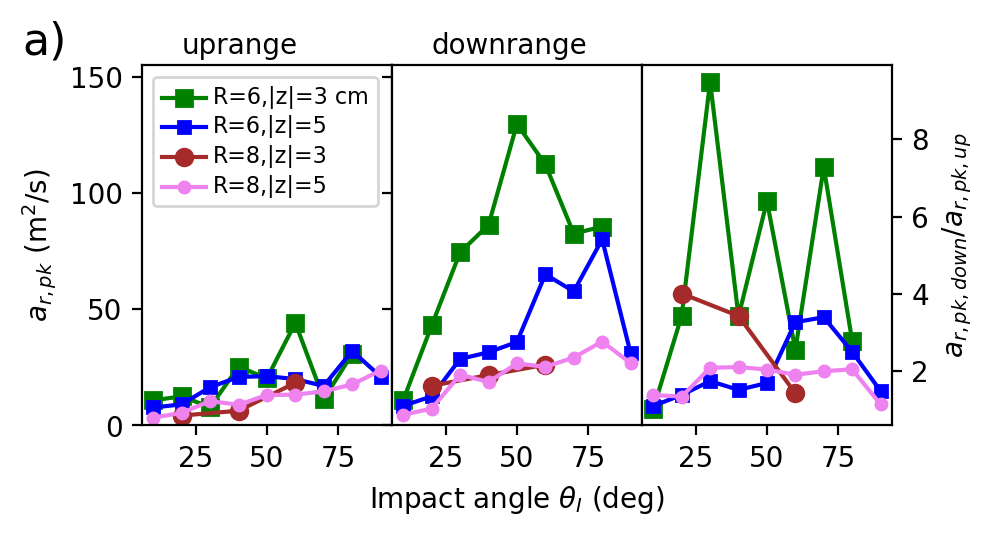

In [21]:
fig,axarr = plt.subplots(1,3,facecolor='white',figsize=(5,2.5),dpi=200,sharex=True,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0,bottom=0.18,top=0.90,right=0.90,left=0.15)
axarr[1].set_xlabel(r'Impact angle $\theta_I$ (deg)')
#axarr[0].set_xlabel(r'Impact angle $\theta_I$ (deg)')

#  velocity peaks as a function of  impact angle
axarr[0].plot(thetalist_R6z3,ar_up_R6z3,'gs-',label='R=6,|z|=3 cm',ms=6) 
axarr[0].plot(thetalist_R6z5,ar_up_R6z5,'bs-',label='R=6,|z|=5',ms=4) 
axarr[0].plot(thetalist_R8z3,ar_up_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown') 
axarr[0].plot(thetalist_R8z5,ar_up_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet') 
axarr[0].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
               loc='upper left')
#axarr[0].text(30,0.056,'uprange')
axarr[0].set_ylim(bottom=-0.002,top=155)
axarr[1].set_ylim(bottom=-0.002,top=155)
axarr[0].text(20,160,'uprange')
axarr[1].text(20,160,'downrange')

axarr[1].plot(thetalist_R6z3,ar_down_R6z3,'gs-',label='R=6,|z|=3',ms=6)
axarr[1].plot(thetalist_R6z5,ar_down_R6z5,'bs-',label='R=6,|z|=5',ms=4)
axarr[1].plot(thetalist_R8z3,ar_down_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown')
axarr[1].plot(thetalist_R8z5,ar_down_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet')
#axarr[1].text(30,0.056,'downrange')
axarr[1].set_yticklabels([])

axarr[2].plot(thetalist_R6z3,ar_down_R6z3/ar_up_R6z3,'gs-',label='R=6,|z|=3',ms=6)
axarr[2].plot(thetalist_R6z5,ar_down_R6z5/ar_up_R6z5,'bs-',label='R=6,|z|=5',ms=4)
axarr[2].plot(thetalist_R8z3,ar_down_R8z3/ar_up_R8z3,'o-',label='R=8,|z|=3',ms=6,color='brown')
axarr[2].plot(thetalist_R8z5,ar_down_R8z5/ar_up_R8z5,'o-',label='R=8,|z|=5',ms=4,color='violet')
axarr[2].yaxis.set_label_position("right")
axarr[2].yaxis.tick_right()
axarr[2].set_ylabel(r'$a_{r,pk,down}/a_{r,pk,up}$')

#axarr[1].legend(handleheight=0.1,handletextpad=0.3,columnspacing=0.2,labelspacing=0.3,fontsize=8,\
#               title='downrange',bbox_to_anchor=[-0.1,0.5,0.5,0.5])
axarr[0].set_ylabel(r'$a_{r,pk}$ (m$^2$/s)')
axarr[0].set_ylim(bottom=-0.002)
axarr[0].text(-36,160,'a)',fontsize=16)
plt.savefig('arpeak.png',dpi=200)
#ax.legend()
#ax.text(25,2.5,'R=8 cm,|z|=5 cm')

-0.051724137931034475
-0.09310344827586206
-0.11379310344827587
0.09310344827586209
0.031034482758620696
0.031034482758620696


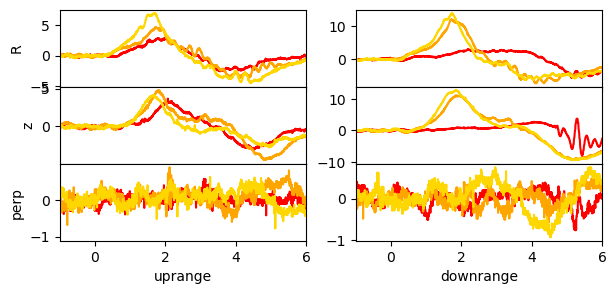

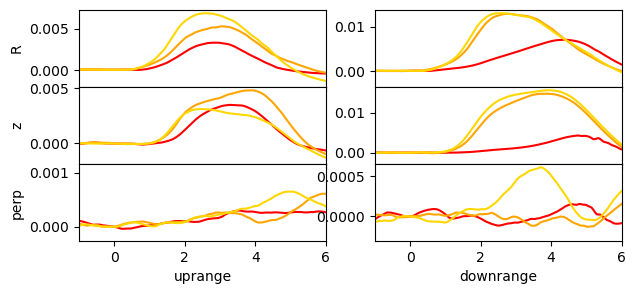

In [132]:
############## lets look at R=10, z=3
dfilelist  = ['t79f.csv','t70f.csv','t61f.csv']
thetalist_R10z3 = np.array([20., 40,  60])
t_impact_list = np.array([582.1, 575.1, 592.8])
R=10.0; z=3.0;
#n_theta_I = len(t_impact_list)
r_R10z3 = np.sqrt(R**2 + z**2)

data_cube_uprange_R10z3,data_cube_downrange_R10z3 = read_data_set(datadir,cal_F5F7,dfilelist,t_impact_list)
adata_cube_uprange_R10z3,   vdata_cube_uprange_R10z3   = mkvels(data_cube_uprange_R10z3,dt)
adata_cube_downrange_R10z3, vdata_cube_downrange_R10z3 = mkvels(data_cube_downrange_R10z3,dt)
u_up_R10z3,u_down_R10z3,theta_up_R10z3,theta_down_R10z3,ur_up_R10z3,ur_down_R10z3  = \
    find_peaks_angles(vdata_cube_uprange_R10z3,vdata_cube_downrange_R10z3,R,z)
a_up_R10z3,a_down_R10z3,atheta_up_R10z3,atheta_down_R10z3,ar_up_R10z3,ar_down_R10z3  = \
    find_peaks_angles(adata_cube_uprange_R10z3,adata_cube_downrange_R10z3,R,z)

display6(adata_cube_uprange_R10z3,adata_cube_downrange_R10z3) # a_R, a_Z up/down range
display6(vdata_cube_uprange_R10z3,vdata_cube_downrange_R10z3) # v_R, v_Z up/down range

-0.09310344827586206
-0.010344827586206862
-0.07241379310344825
0.09310344827586209
0.15517241379310348
0.051724137931034475


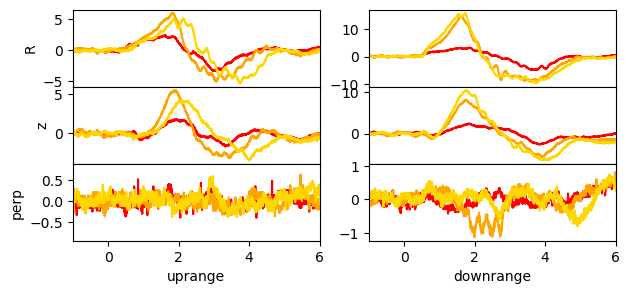

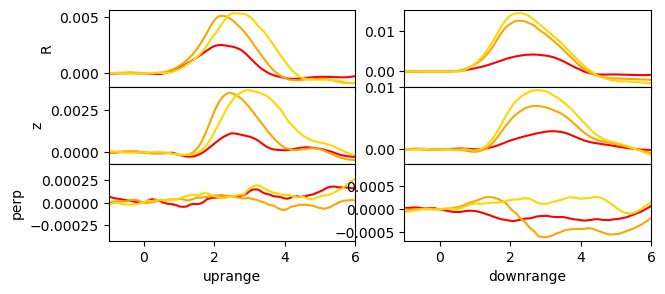

In [133]:
############## lets look at R=10, z=5
dfilelist  = ['t73f.csv','t64f.csv','t55f.csv']
thetalist_R10z5 = np.array([20., 40,  60])
t_impact_list = np.array([599.8, 575.9, 591.0]) 
R=10.0; z=5.0;
#n_theta_I = len(t_impact_list)
r_R10z5 = np.sqrt(R**2 + z**2)

data_cube_uprange_R10z5,data_cube_downrange_R10z5 = read_data_set(datadir,cal_F5F7,dfilelist,t_impact_list)
adata_cube_uprange_R10z5,   vdata_cube_uprange_R10z5   = mkvels(data_cube_uprange_R10z5,dt)
adata_cube_downrange_R10z5, vdata_cube_downrange_R10z5 = mkvels(data_cube_downrange_R10z5,dt)
u_up_R10z5,u_down_R10z5,theta_up_R10z5,theta_down_R10z5,ur_up_R10z5,ur_down_R10z5  = \
    find_peaks_angles(vdata_cube_uprange_R10z5,vdata_cube_downrange_R10z5,R,z)
a_up_R10z5,a_down_R10z5,atheta_up_R10z5,atheta_down_R10z5,ar_up_R10z5,ar_down_R10z5  = \
    find_peaks_angles(adata_cube_uprange_R10z5,adata_cube_downrange_R10z5,R,z)

display6(adata_cube_uprange_R10z5,adata_cube_downrange_R10z5) # a_R, a_Z up/down range
display6(vdata_cube_uprange_R10z5,vdata_cube_downrange_R10z5) # v_R, v_Z up/down range

0.15517241379310348
0.031034482758620696
-0.010344827586206862
0.13448275862068965
-0.010344827586206862
0.051724137931034475


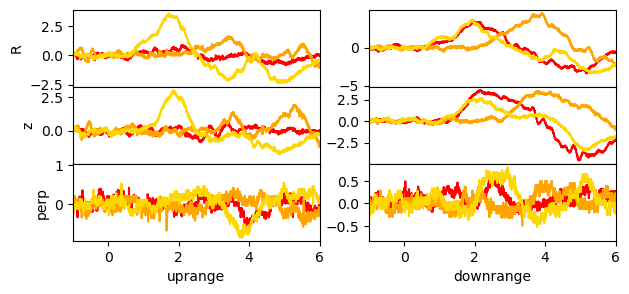

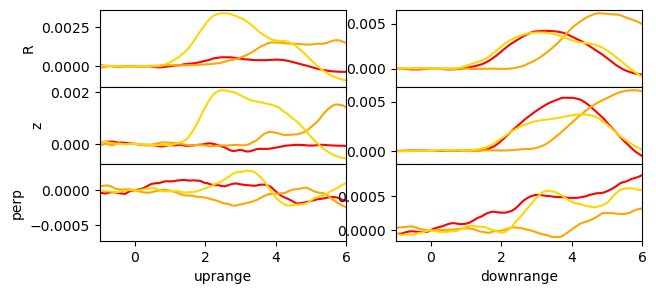

In [134]:
############## lets look at R=12, z=3
dfilelist  = ['t80f.csv','t71f.csv','t62f.csv']
thetalist_R12z3 = np.array([20., 40,  60])
t_impact_list = np.array([594.7, 575.9, 592.2])
R=12.0; z=3.0;
#n_theta_I = len(t_impact_list)
r_R12z3 = np.sqrt(R**2 + z**2)

data_cube_uprange_R12z3,data_cube_downrange_R12z3 = read_data_set(datadir,cal_F5F7,dfilelist,t_impact_list)
adata_cube_uprange_R12z3,   vdata_cube_uprange_R12z3   = mkvels(data_cube_uprange_R12z3,dt)
adata_cube_downrange_R12z3, vdata_cube_downrange_R12z3 = mkvels(data_cube_downrange_R12z3,dt)
u_up_R12z3,u_down_R12z3,theta_up_R12z3,theta_down_R12z3,ur_up_R12z3,ur_down_R12z3  = \
    find_peaks_angles(vdata_cube_uprange_R12z3,vdata_cube_downrange_R12z3,R,z)
a_up_R12z3,a_down_R12z3,atheta_up_R12z3,atheta_down_R12z3,ar_up_R12z3,ar_down_R12z3  = \
    find_peaks_angles(adata_cube_uprange_R12z3,adata_cube_downrange_R12z3,R,z)

display6(adata_cube_uprange_R12z3,adata_cube_downrange_R12z3) # a_R, a_Z up/down range
display6(vdata_cube_uprange_R12z3,vdata_cube_downrange_R12z3) # v_R, v_Z up/down range

In [25]:
bcolorlist = ['grey','brown', 'purple','magenta','blue','cyan','green','orange','red']
#              0      1         2       3         4       5      6       7       8
# Bingcheng's color list 
#             10,      20,     30      40         50      60     70    80       90 

In [90]:
tR6z5 = np.arctan2(5.,6.)*180./np.pi
tR6z3 = np.arctan2(3.,6.)*180./np.pi
tR10z5 = np.arctan2(5.,10.)*180./np.pi
tR10z3 = np.arctan2(3.,10.)*180./np.pi
print('R6  {:.1f} {:.1f} '.format( tR6z3, tR6z5))
print('R10 {:.1f} {:.1f} '.format(  tR10z3, tR10z5))

R6  26.6 39.8 
R10 16.7 26.6 


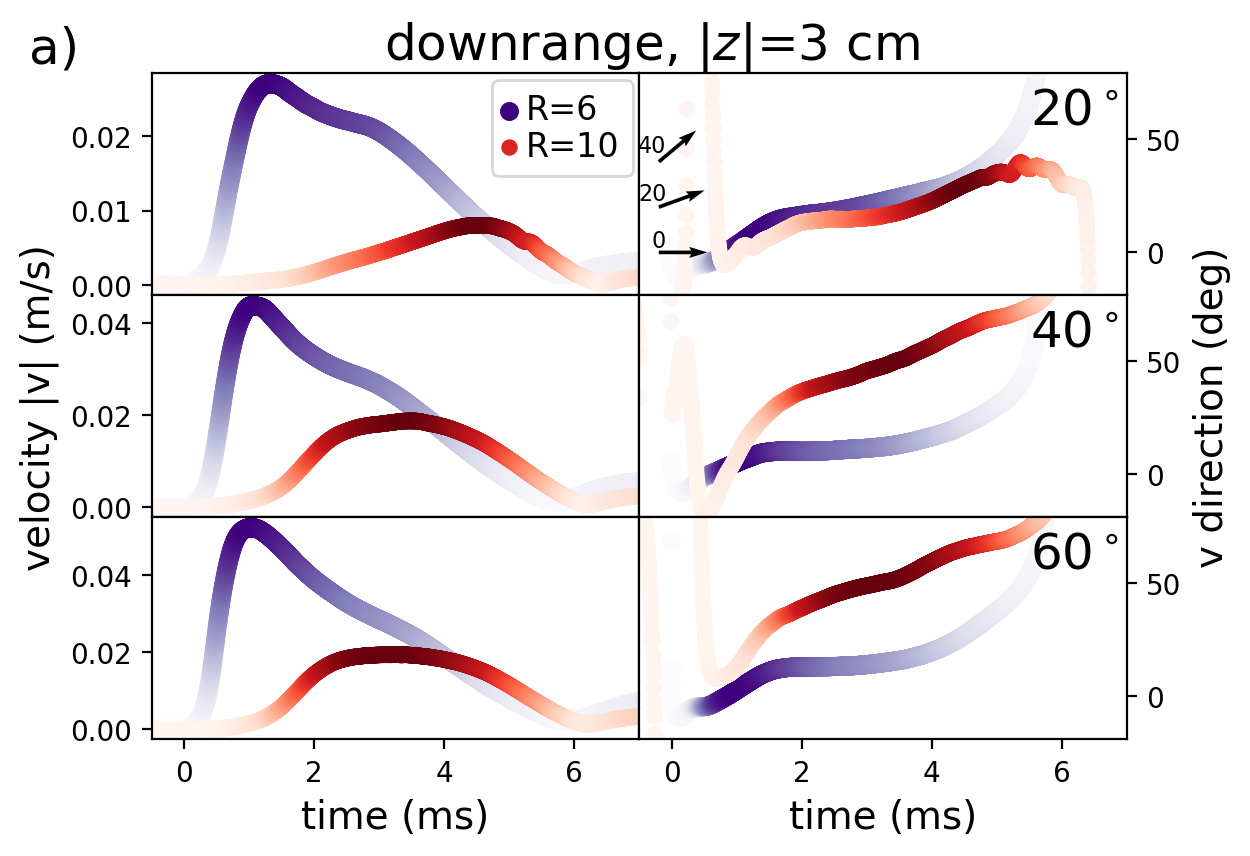

In [123]:
fig,axarr = plt.subplots(3,2,facecolor='white',figsize=(6.5,4.5),dpi=200,sharex=True,sharey=False)
plt.subplots_adjust(hspace=0.0,wspace=0.,bottom=0.16,top=0.90,right=0.90,left=0.15)
#cmapR = matplotlib.cm.get_cmap('Reds')
cmapR = matplotlib.colormaps['Reds']
Rtop = cmapR(0.7)
cmapP = matplotlib.colormaps['Purples']
Ptop = cmapP(1.)
axarr[0,0].set_xlim([-0.5,7])
sP = 34;  sR = 24

#tlin = np.linspace(0.3,6.9,100)
#axarr[0,1].plot(tlin,-tR6z3 + tlin*0,'--',alpha=0.5,lw=1,color=Ptop,zorder=1)
#axarr[0,1].plot(tlin,-tR10z3 + tlin*0,':',alpha=0.5,lw=1,color=Rtop,zorder=1)
#tlin = np.linspace(-0.3,6.9,100)
#for j in range (1,3):
#    axarr[j,1].plot(tlin,-tR6z3 + tlin*0,'--',alpha=0.5,lw=1,color=Ptop,zorder=1)
#    axarr[j,1].plot(tlin,-tR10z3 + tlin*0,':',alpha=0.5,lw=1,color=Rtop,zorder=1)

tarr = np.squeeze(vdata_cube_downrange_R6z3[0,0,:])
i=1; # 20 degrees
um,utheta = umag(vdata_cube_downrange_R6z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[0,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[0,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[0,0].plot(tarr,um,color=bcolorlist[1],label=r'R=6')
axarr[0,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_downrange_R10z3[0,0,:])
i=0; # 20 degrees
um,utheta = umag(vdata_cube_downrange_R10z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[0,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[0,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[0,0].plot(tarr,um,'--',color=bcolorlist[1],label=r'R=10')
axarr[0,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

axarr[0,0].legend(labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
                  borderaxespad=0.2,fontsize=12)

tarr = np.squeeze(vdata_cube_downrange_R6z3[0,0,:])
i=3; # 40 degrees
um,utheta = umag(vdata_cube_downrange_R6z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[1,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[1,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[1,0].plot(tarr,um,'-',color=bcolorlist[3])
axarr[1,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_downrange_R10z3[0,0,:])
i=1; # 40 degrees
um,utheta = umag(vdata_cube_downrange_R10z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[1,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[1,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[1,0].plot(tarr,um,'--',color=bcolorlist[3])
axarr[1,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

#axarr[1,0].legend(title=r'$40^{\!\!\circ}\!,\!|z|\!=\!3$',labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
#                 borderaxespad=0.2)

tarr = np.squeeze(vdata_cube_downrange_R6z3[0,0,:])
i=5; # 60 degrees
um,utheta = umag(vdata_cube_downrange_R6z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[2,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[2,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[2,0].plot(tarr,um,'-',color=bcolorlist[5],alpha=0.5)
axarr[2,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_downrange_R10z3[0,0,:])
i=2; # 60 degrees
um,utheta = umag(vdata_cube_downrange_R10z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[2,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[2,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[2,0].plot(tarr,um,'--',color=bcolorlist[5])
axarr[2,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

#axarr[2,0].legend(title=r'$60^{\!\!\circ}\!,\!|z|\!=\!3$',labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
#                 borderaxespad=0.2)

for j in range(3):
    axarr[j,1].set_ylim([1-20,99-20])
    axarr[j,1].yaxis.set_label_position("right")
    axarr[j,1].yaxis.tick_right()
    
axarr[1,0].set_ylabel('velocity |v| (m/s)',fontsize=14)
axarr[2,0].set_xlabel('time (ms)',fontsize=14)
axarr[2,1].set_xlabel('time (ms)',fontsize=14)
axarr[1,1].set_ylabel('v direction (deg)',fontsize=14)
axarr[0,1].text(-0.3,91,'downrange, $|z|$=3 cm',fontsize=18,ha='center',va='center')

xth=6.2;yth=63
axarr[0,1].text(xth,yth,r'$20^\circ$',fontsize=18,ha='center',va='center')
axarr[1,1].text(xth,yth,r'$40^\circ$',fontsize=18,ha='center',va='center')
axarr[2,1].text(xth,yth,r'$60^\circ$',fontsize=18,ha='center',va='center')


axarr[0,1].text(-9.5,90,'a)',fontsize=18,ha='center',va='center')

#axarr[0,1].arrow(-0.3,0,1,0,width=3,head_width=0.8,shape='full')
#axarr[0,1].annotate('40', xy=(0.46, 40+20), xytext=(-0.3, 40),
#            arrowprops=dict(facecolor='black',width=2,headwidth=5,headlength=5),)
#axarr[0,1].annotate('20', xy=(0.48, 20+10), xytext=(-0.3, 20),
#            arrowprops=dict(facecolor='black',width=2,headwidth=5,headlength=5),)
#axarr[0,1].annotate('0', xy=(0.51, 0), xytext=(-0.3, 0),
#            arrowprops=dict(facecolor='black',width=2,headwidth=5,headlength=5),)

x_arrows = np.zeros(3) -0.2
y_arrows = np.arange(3)*20
t_arrows = y_arrows*np.pi/180
dx_arrows = np.cos(t_arrows)
dy_arrows = np.sin(t_arrows)
axarr[0,1].quiver(x_arrows,y_arrows,dx_arrows,dy_arrows,angles='uv',scale=10)
axarr[0,1].text(x_arrows[0],y_arrows[0]+5,'0',ha='center',va='center',fontsize=8)
axarr[0,1].text(x_arrows[1]-0.1,y_arrows[1]+6,'20',ha='center',va='center',fontsize=8)
axarr[0,1].text(x_arrows[2]-0.1,y_arrows[2]+7,'40',ha='center',va='center',fontsize=8)

plt.savefig('Rpulse_downrange.png',dpi=200)

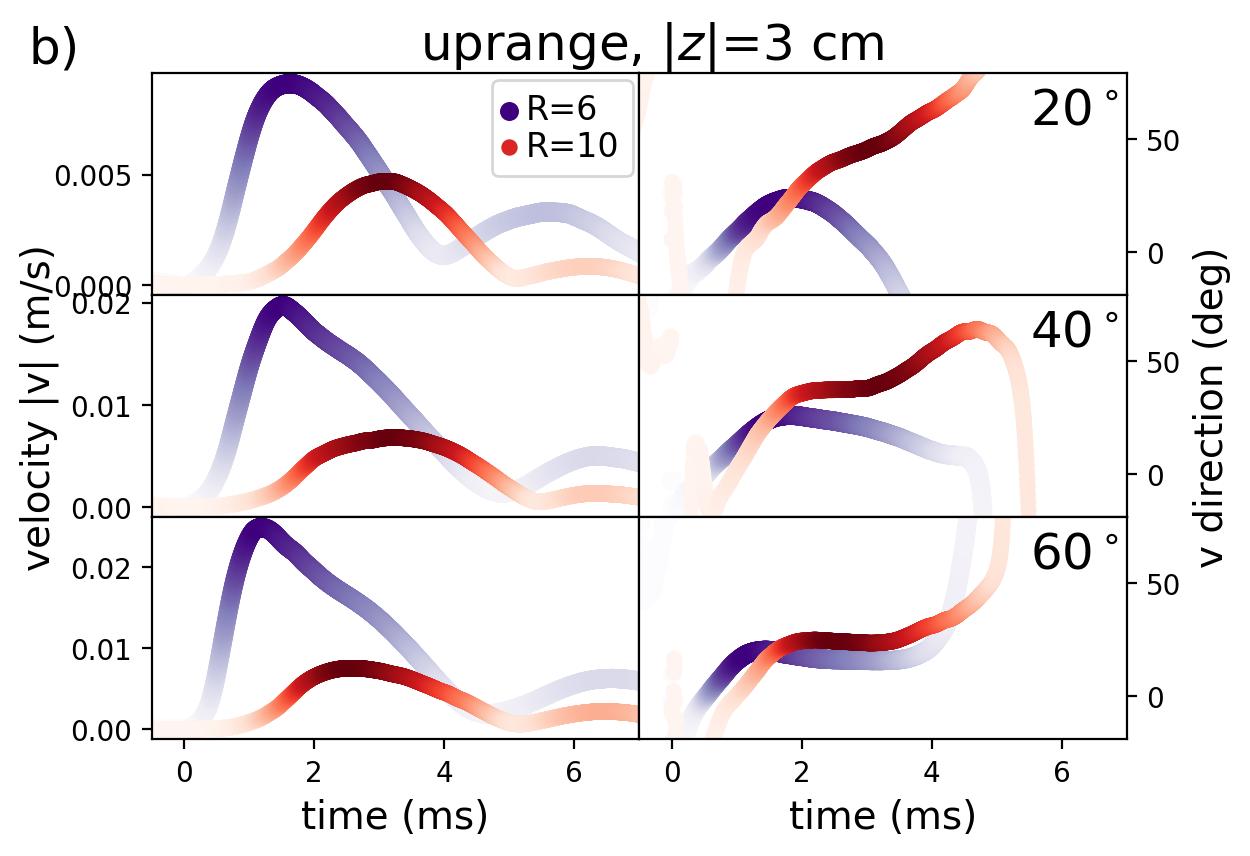

In [126]:
fig,axarr = plt.subplots(3,2,facecolor='white',figsize=(6.5,4.5),dpi=200,sharex=True,sharey=False)
plt.subplots_adjust(hspace=0.0,wspace=0.,bottom=0.16,top=0.90,right=0.90,left=0.15)
#cmapR = matplotlib.cm.get_cmap('Reds')
cmapR = matplotlib.colormaps['Reds']
Rtop = cmapR(0.7)
cmapP = matplotlib.colormaps['Purples']
Ptop = cmapP(1.)
axarr[0,0].set_xlim([-0.5,7])
sP = 34;  sR = 24

tlin = np.linspace(-0.3,6.9,100)
#for j in range (0,3):
#    axarr[j,1].plot(tlin,-tR6z3 + tlin*0,'--',alpha=0.5,lw=1,color=Ptop,zorder=1)
#    axarr[j,1].plot(tlin,-tR10z3 + tlin*0,':',alpha=0.5,lw=1,color=Rtop,zorder=1)

tarr = np.squeeze(vdata_cube_uprange_R6z3[0,0,:])
i=1; # 20 degrees
um,utheta = umag(vdata_cube_uprange_R6z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[0,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[0,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[0,0].plot(tarr,um,color=bcolorlist[1],label=r'R=6')
axarr[0,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_uprange_R10z3[0,0,:])
i=0; # 20 degrees
um,utheta = umag(vdata_cube_uprange_R10z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[0,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[0,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[0,0].plot(tarr,um,'--',color=bcolorlist[1],label=r'R=10')
axarr[0,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

axarr[0,0].legend(labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
                  borderaxespad=0.2,fontsize=12)

tarr = np.squeeze(vdata_cube_uprange_R6z3[0,0,:])
i=3; # 40 degrees
um,utheta = umag(vdata_cube_uprange_R6z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[1,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[1,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[1,0].plot(tarr,um,'-',color=bcolorlist[3])
axarr[1,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_uprange_R10z3[0,0,:])
i=1; # 40 degrees
um,utheta = umag(vdata_cube_uprange_R10z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[1,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[1,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[1,0].plot(tarr,um,'--',color=bcolorlist[3])
axarr[1,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

#axarr[1,0].legend(title=r'$40^{\!\!\circ}\!,\!|z|\!=\!3$',labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
#                 borderaxespad=0.2)

tarr = np.squeeze(vdata_cube_uprange_R6z3[0,0,:])
i=5; # 60 degrees
um,utheta = umag(vdata_cube_uprange_R6z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[2,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[2,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[2,0].plot(tarr,um,'-',color=bcolorlist[5],alpha=0.5)
axarr[2,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_uprange_R10z3[0,0,:])
i=2; # 60 degrees
um,utheta = umag(vdata_cube_uprange_R10z3,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[2,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[2,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[2,0].plot(tarr,um,'--',color=bcolorlist[5])
axarr[2,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

#axarr[2,0].legend(title=r'$60^{\!\!\circ}\!,\!|z|\!=\!3$',labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
#                 borderaxespad=0.2)


for j in range(3):
    axarr[j,1].set_ylim([1-20,99-20])
    axarr[j,1].yaxis.set_label_position("right")
    axarr[j,1].yaxis.tick_right()
    
axarr[1,0].set_ylabel('velocity |v| (m/s)',fontsize=14)
axarr[2,0].set_xlabel('time (ms)',fontsize=14)
axarr[2,1].set_xlabel('time (ms)',fontsize=14)
axarr[1,1].set_ylabel('v direction (deg)',fontsize=14)
axarr[0,1].text(-0.3,91,'uprange, $|z|$=3 cm',fontsize=18,ha='center',va='center')

xth=6.2;yth=63
axarr[0,1].text(xth,yth,r'$20^\circ$',fontsize=18,ha='center',va='center')
axarr[1,1].text(xth,yth,r'$40^\circ$',fontsize=18,ha='center',va='center')
axarr[2,1].text(xth,yth,r'$60^\circ$',fontsize=18,ha='center',va='center')

axarr[0,1].text(-9.5,90,'b)',fontsize=18,ha='center',va='center')

plt.savefig('Rpulse_uprange.png',dpi=200)

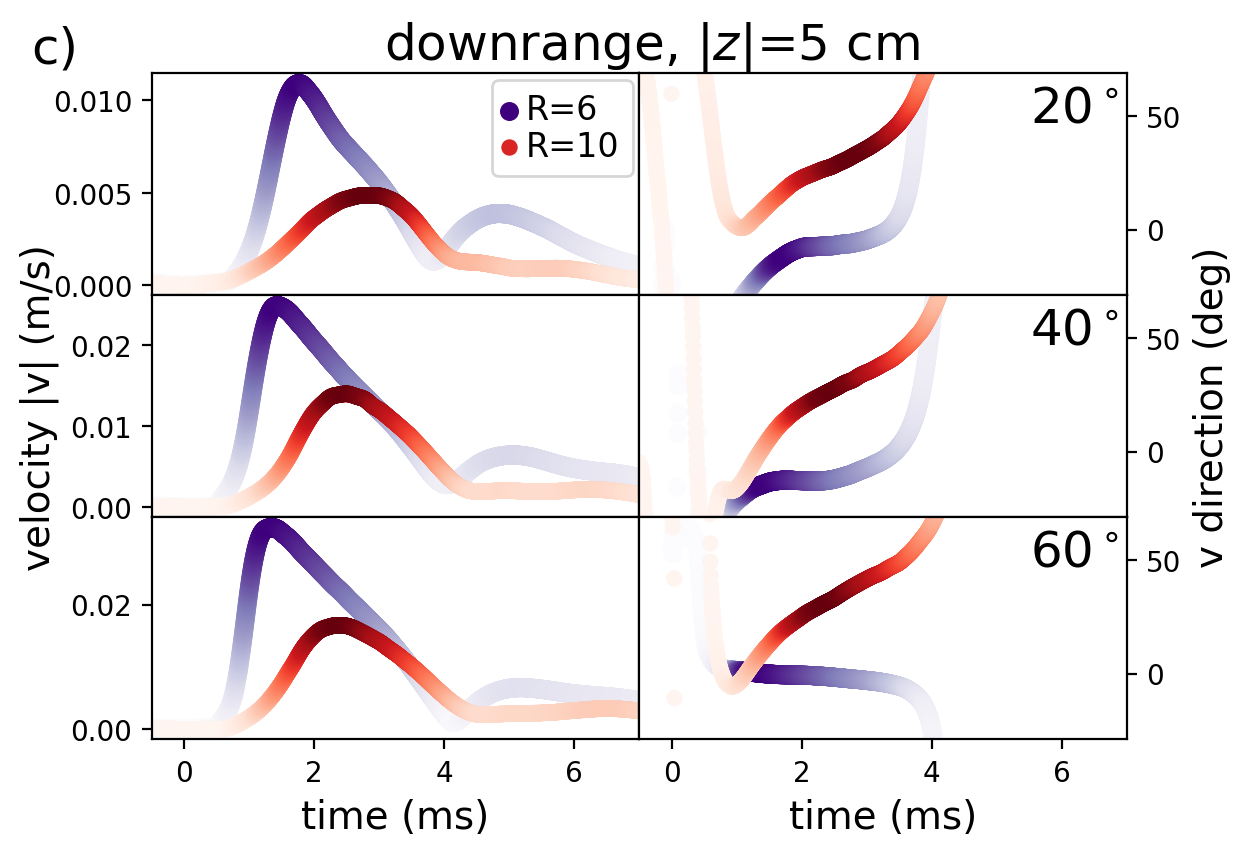

In [127]:
fig,axarr = plt.subplots(3,2,facecolor='white',figsize=(6.5,4.5),dpi=200,sharex=True,sharey=False)
plt.subplots_adjust(hspace=0.0,wspace=0.,bottom=0.16,top=0.90,right=0.90,left=0.15)
#cmapR = matplotlib.cm.get_cmap('Reds')
cmapR = matplotlib.colormaps['Reds']
Rtop = cmapR(0.7)
cmapP = matplotlib.colormaps['Purples']
Ptop = cmapP(1.)
axarr[0,0].set_xlim([-0.5,7])
sP = 34;  sR = 24

tlin = np.linspace(-0.3,6.9,100)
#for j in range (3):
#    axarr[j,1].plot(tlin,-tR6z5 + tlin*0,'--',alpha=0.5,lw=1,color=Ptop,zorder=1)
#    axarr[j,1].plot(tlin,-tR10z5 + tlin*0,':',alpha=0.5,lw=1,color=Rtop,zorder=1)

tarr = np.squeeze(vdata_cube_downrange_R6z5[0,0,:])
i=1; # 20 degrees
um,utheta = umag(vdata_cube_downrange_R6z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[0,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[0,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[0,0].plot(tarr,um,color=bcolorlist[1],label=r'R=6')
axarr[0,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_downrange_R10z5[0,0,:])
i=0; # 20 degrees
um,utheta = umag(vdata_cube_downrange_R10z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[0,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[0,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[0,0].plot(tarr,um,'--',color=bcolorlist[1],label=r'R=10')
axarr[0,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

axarr[0,0].legend(labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
                  borderaxespad=0.2,fontsize=12)

tarr = np.squeeze(vdata_cube_downrange_R6z5[0,0,:])+0.1
i=3; # 40 degrees
um,utheta = umag(vdata_cube_downrange_R6z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[1,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[1,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[1,0].plot(tarr,um,'-',color=bcolorlist[3])
axarr[1,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_downrange_R10z5[0,0,:])+0.1
i=1; # 40 degrees
um,utheta = umag(vdata_cube_downrange_R10z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[1,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[1,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[1,0].plot(tarr,um,'--',color=bcolorlist[3])
axarr[1,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

#axarr[1,0].legend(title=r'$40^{\!\!\circ}\!,\!|z|\!=\!5$',labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
#                 borderaxespad=0.2)

tarr = np.squeeze(vdata_cube_downrange_R6z5[0,0,:])
i=5; # 60 degrees
um,utheta = umag(vdata_cube_downrange_R6z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[2,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[2,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[2,0].plot(tarr,um,'-',color=bcolorlist[5],alpha=0.5)
axarr[2,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_downrange_R10z5[0,0,:])
i=2; # 60 degrees
um,utheta = umag(vdata_cube_downrange_R10z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[2,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[2,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[2,0].plot(tarr,um,'--',color=bcolorlist[5])
axarr[2,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

#axarr[2,0].legend(title=r'$60^{\!\!\circ}\!,\!|z|\!=\!5$',labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
#                 borderaxespad=0.2)


for j in range(3):
    axarr[j,1].set_ylim([1-30,99-30])
    axarr[j,1].yaxis.set_label_position("right")
    axarr[j,1].yaxis.tick_right()
    
axarr[1,0].set_ylabel('velocity |v| (m/s)',fontsize=14)
axarr[2,0].set_xlabel('time (ms)',fontsize=14)
axarr[2,1].set_xlabel('time (ms)',fontsize=14)
axarr[1,1].set_ylabel('v direction (deg)',fontsize=14)

xth=6.2;yth=54
axarr[0,1].text(xth,yth,r'$20^\circ$',fontsize=18,ha='center',va='center')
axarr[1,1].text(xth,yth,r'$40^\circ$',fontsize=18,ha='center',va='center')
axarr[2,1].text(xth,yth,r'$60^\circ$',fontsize=18,ha='center',va='center')

axarr[0,1].text(-0.3,81,'downrange, $|z|$=5 cm',fontsize=18,ha='center',va='center')

axarr[0,1].text(-9.5,80,'c)',fontsize=18,ha='center',va='center')

plt.savefig('Rpulse_downrange2.png',dpi=200)

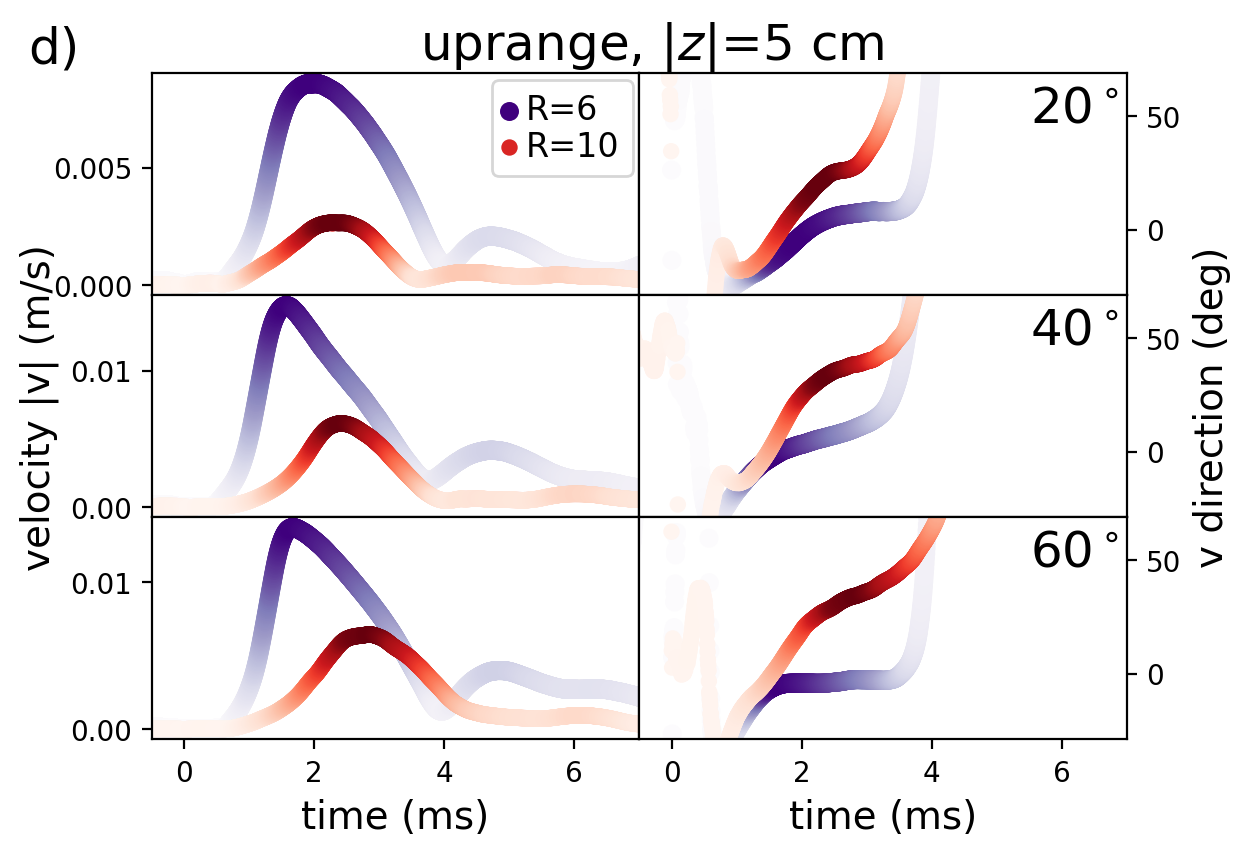

In [120]:
fig,axarr = plt.subplots(3,2,facecolor='white',figsize=(6.5,4.5),dpi=200,sharex=True,sharey=False)
plt.subplots_adjust(hspace=0.0,wspace=0.,bottom=0.16,top=0.90,right=0.90,left=0.15)
#cmapR = matplotlib.cm.get_cmap('Reds')
cmapR = matplotlib.colormaps['Reds']
Rtop = cmapR(0.7)
cmapP = matplotlib.colormaps['Purples']
Ptop = cmapP(1.)
axarr[0,0].set_xlim([-0.5,7])
sP = 34;  sR = 24

tlin = np.linspace(-0.3,6.9,100)
#for j in range (3):
#    axarr[j,1].plot(tlin,-tR6z5 + tlin*0,'--',alpha=0.5,lw=1,color=Ptop,zorder=1)
#    axarr[j,1].plot(tlin,-tR10z5 + tlin*0,':',alpha=0.5,lw=1,color=Rtop,zorder=1)

tarr = np.squeeze(vdata_cube_uprange_R6z5[0,0,:])
i=1; # 20 degrees
um,utheta = umag(vdata_cube_uprange_R6z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[0,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[0,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[0,0].plot(tarr,um,color=bcolorlist[1],label=r'R=6')
axarr[0,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_uprange_R10z5[0,0,:])
i=0; # 20 degrees
um,utheta = umag(vdata_cube_uprange_R10z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[0,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[0,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[0,0].plot(tarr,um,'--',color=bcolorlist[1],label=r'R=10')
axarr[0,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

axarr[0,0].legend(labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
                  borderaxespad=0.2,fontsize=12)

tarr = np.squeeze(vdata_cube_uprange_R6z5[0,0,:])+0.1
i=3; # 40 degrees
um,utheta = umag(vdata_cube_uprange_R6z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[1,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[1,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[1,0].plot(tarr,um,'-',color=bcolorlist[3])
axarr[1,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_uprange_R10z3[0,0,:])+0.1
i=1; # 40 degrees
um,utheta = umag(vdata_cube_uprange_R10z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[1,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[1,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[1,0].plot(tarr,um,'--',color=bcolorlist[3])
axarr[1,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

#axarr[1,0].legend(title=r'$40^{\!\!\circ}\!,\!|z|\!=\!5$',labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
#                 borderaxespad=0.2)

tarr = np.squeeze(vdata_cube_uprange_R6z5[0,0,:])
i=5; # 60 degrees
um,utheta = umag(vdata_cube_uprange_R6z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[2,0].scatter(tarr[imax],um[imax],color=Ptop,label='R=6',s=sP)
axarr[2,0].scatter(tarr,um,c=um,cmap='Purples',s=sP)
#axarr[2,0].plot(tarr,um,'-',color=bcolorlist[5],alpha=0.5)
axarr[2,1].scatter(tarr,utheta,c=um,cmap='Purples',s=sP)

tarr = np.squeeze(vdata_cube_uprange_R10z5[0,0,:])
i=2; # 60 degrees
um,utheta = umag(vdata_cube_uprange_R10z5,i);  utheta *= 180/np.pi
imax= np.argmax(um);  axarr[2,0].scatter(tarr[imax],um[imax],color=Rtop,label='R=10',s=sR)
axarr[2,0].scatter(tarr,um,c=um,cmap='Reds',s=sR)
#axarr[2,0].plot(tarr,um,'--',color=bcolorlist[5])
axarr[2,1].scatter(tarr,utheta,c=um,cmap='Reds',s=sR)

#axarr[2,0].legend(title=r'$60^{\!\!\circ}\!,\!|z|\!=\!5$',labelspacing=0.1,handlelength=0.2,handletextpad=0.4,\
#                 borderaxespad=0.2)

for j in range(3):
    axarr[j,1].set_ylim([1-30,99-30])
    axarr[j,1].yaxis.set_label_position("right")
    axarr[j,1].yaxis.tick_right()
    
xth=6.2;yth=54
axarr[0,1].text(xth,yth,r'$20^\circ$',fontsize=18,ha='center',va='center')
axarr[1,1].text(xth,yth,r'$40^\circ$',fontsize=18,ha='center',va='center')
axarr[2,1].text(xth,yth,r'$60^\circ$',fontsize=18,ha='center',va='center')
    
axarr[1,0].set_ylabel('velocity |v| (m/s)',fontsize=14)
axarr[2,0].set_xlabel('time (ms)',fontsize=14)
axarr[2,1].set_xlabel('time (ms)',fontsize=14)
axarr[1,1].set_ylabel('v direction (deg)',fontsize=14)
axarr[0,1].text(-0.3,81,r'uprange, $|z|$=5 cm',fontsize=18,ha='center',va='center')

axarr[0,1].text(-9.5,80,'d)',fontsize=18,ha='center',va='center')

plt.savefig('Rpulse_uprange2.png',dpi=200)